In [1]:
import pandas as pd

df = pd.read_csv("/kaggle/input/redditmentalhealth-dataset/bert_clean_balanced_reddit.csv")
df = df[['text', 'label']]

print(df['label'].value_counts())

df_0 = df[df['label']==0].sample(n=60000,random_state=42)
df_1 = df[df['label']==1].sample(n=60000,random_state=42)
df_small = pd.concat([df_0,df_1]).sample(frac=1,random_state=42).reset_index(drop=True)
df_small.to_csv("bert_small_10.csv", index=False)

df_1 = pd.read_csv("bert_small_10.csv")

label
1    61158
0    61158
Name: count, dtype: int64


In [2]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def encode(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=256,
        return_tensors='pt'
    )

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_1['text'].tolist(), df_1['label'].tolist(), test_size=0.2, random_state=42)

train_encodings = encode(train_texts)
test_encodings = encode(test_texts)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [3]:
import torch

class RedditDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {'input_ids': self.encodings['input_ids'][idx],
            'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset = RedditDataset(train_encodings, train_labels)
test_dataset = RedditDataset(test_encodings, test_labels)

# Baseline

Accuracy: 0.9487916666666667
Logistic Regression Performance:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     12007
           1       0.95      0.94      0.95     11993

    accuracy                           0.95     24000
   macro avg       0.95      0.95      0.95     24000
weighted avg       0.95      0.95      0.95     24000

Confusion Matrix:
 [[11469   538]
 [  691 11302]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


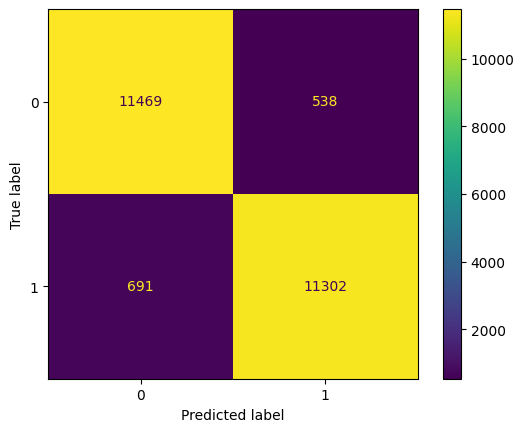

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_1['text'])
y = df_1['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Logistic Regression Performance:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
ConfusionMatrixDisplay(cm).plot()

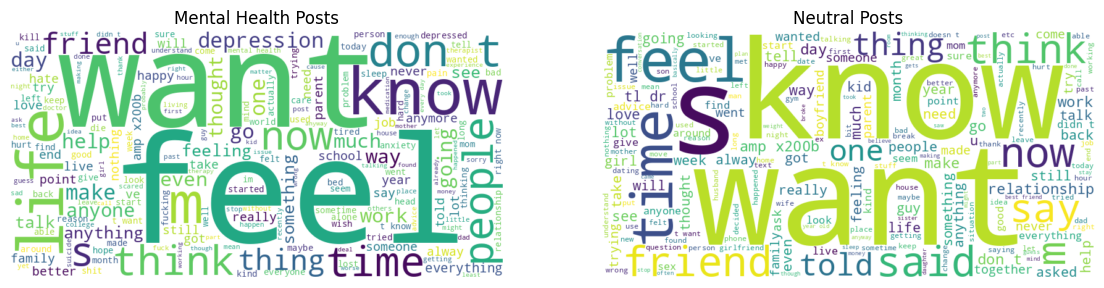

In [5]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

texts = df_1["text"].tolist()
labels = df_1["label"].tolist()
mh_texts = " ".join([texts[i] for i in range (len(texts)) if labels[i] == 1])
neutral_texts = " ".join([texts[i] for i in range (len(texts)) if labels[i] == 0])

stopwords = set(STOPWORDS)
stopwords.update(["the", "and", "to", "a", "of", "in"])

wc_mental = WordCloud(stopwords=stopwords, width=800, height=400, background_color='white').generate(mh_texts)
wc_neutral = WordCloud(stopwords=stopwords, width=800, height=400, background_color='white').generate(neutral_texts)

plt.figure(figsize=(14, 6))

plt.subplot(1,2,1)
plt.imshow(wc_mental, interpolation='bilinear')
plt.axis('off')
plt.title("Mental Health Posts")

plt.subplot(1,2,2)
plt.imshow(wc_neutral, interpolation='bilinear')
plt.axis('off')
plt.title("Neutral Posts")

plt.show()

In [6]:
import numpy as np

def load_glove_embeddings(path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.05, 0.05, (len(word2idx), embedding_dim))
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            if word in word2idx:
                vector = np.array(parts[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

# Custom Transformer

In [7]:
import torch.nn as nn

class SmallTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, ff_dim, max_len, dropout, pretrained_embeddings=None):
        super(SmallTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            self.embedding.weight.requires_grad = True  # Trainable GloVe

        self.pos_embedding = nn.Parameter(torch.zeros(1, max_len, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(embed_dim, 2)

    def forward(self, input_ids):
        x = self.embedding(input_ids) + self.pos_embedding[:, :input_ids.size(1), :]
        x = self.transformer(x)
        x = x[:, 0]  #first position
        x = self.dropout(x)
        return self.fc(x)

In [8]:
from collections import defaultdict
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
word2idx = tokenizer.vocab

glove_path = "/kaggle/input/working/glove.6B.100d.txt"
glove_tensor = load_glove_embeddings(glove_path, word2idx, embedding_dim=100)

In [9]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallTransformer(
    vocab_size=len(word2idx),
    embed_dim=100,
    num_heads=4,
    num_layers=3,
    ff_dim=256,
    dropout=0.1,
    max_len=256,
    pretrained_embeddings=glove_tensor
).to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=1)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Hyperparameter Tuning

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def train_and_eval(model, train_loader, test_loader, optimizer, device):
    best_eval_loss = float('inf')
    patience = 2
    counter = 0
    best_model_state = None
    train_losses = []
    eval_losses = []
    eval_accuracies = []
    eval_precisions = []
    eval_recalls = []
    eval_f1s = []
    for epoch in range(10):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids)
            loss = nn.functional.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}")
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids)
                loss = nn.CrossEntropyLoss()(outputs, labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        avg_eval_loss = val_loss / len(test_loader)
        scheduler.step(avg_eval_loss)
        eval_losses.append(avg_eval_loss)
        acc = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
        eval_accuracies.append(acc)
        eval_precisions.append(precision)
        eval_recalls.append(recall)
        eval_f1s.append(f1)
        print(f"Epoch {epoch+1} - Eval Loss: {avg_eval_loss:.4f}")
        print(f"Accuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")
        # Early stopping condition
        if avg_eval_loss < best_eval_loss:
            best_eval_loss = avg_eval_loss
            best_model_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                return acc, precision, recall, f1
                break
                
    if best_model_state:
        model.load_state_dict(best_model_state)
    return acc, precision, recall, f1

learning_rates = [1e-4, 5e-5, 3e-5]
dropouts = [0.1, 0.2]
ff_dims = [128, 256]
results = []

for lr in learning_rates:
    for dropout in dropouts:
        for ff_dim in ff_dims:
            print(f"\nTesting: LR={lr}, Dropout={dropout}, FF={ff_dim}")
            model = SmallTransformer(
                    vocab_size=len(word2idx),
                    embed_dim=100,
                    num_heads=4,
                    num_layers=3,
                    ff_dim=ff_dim,
                    dropout=dropout,
                    max_len=256,
                    pretrained_embeddings=glove_tensor
                    ).to(device)
            optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
            scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=1)
            acc, prec, rec, f1 = train_and_eval(model, train_loader, test_loader, optimizer, device)
            print(f"Acc: {acc:.4f} | P: {prec:.4f} | R: {rec:.4f} | F1: {f1:.4f}")
            results.append((lr, dropout, ff_dim, acc, prec, rec, f1))
results.sort(key=lambda x: x[-1], reverse=True)
best = results[0]
print(f"\nBest Config → LR={best[0]}, Dropout={best[1]}, FF={best[2]}")
print(f"Accuracy: {best[3]:.4f}, F1: {best[6]:.4f}")

Training

In [10]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
best_eval_loss = float('inf')
patience = 2
counter = 0

train_losses = []
eval_losses = []
eval_accuracies = []
eval_precisions = []
eval_recalls = []
eval_f1s = []
for epoch in range(10):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids)
        loss = nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}")
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids)
            loss = nn.functional.cross_entropy(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_eval_loss = val_loss / len(test_loader)
    scheduler.step(avg_eval_loss)
    eval_losses.append(avg_eval_loss)
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    eval_accuracies.append(acc)
    eval_precisions.append(precision)
    eval_recalls.append(recall)
    eval_f1s.append(f1)
    print(f"Epoch {epoch+1} - Eval Loss: {avg_eval_loss:.4f}")
    print(f"Accuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")

    if avg_eval_loss < best_eval_loss:
        best_eval_loss = avg_eval_loss
        counter = 0
        torch.save(model.state_dict(), "best_custom_model.pt")
        print("Saved model")
    else:
        counter+=1
        if counter >= patience:
            print("Early Stopping")
            break

100%|██████████| 6000/6000 [01:18<00:00, 76.51it/s]


Epoch 1 - Training Loss: 0.1948
Epoch 1 - Eval Loss: 0.1224
Accuracy: 0.9539 | Precision: 0.9530 | Recall: 0.9548 | F1 Score: 0.9539
Saved model


100%|██████████| 6000/6000 [01:18<00:00, 76.39it/s]


Epoch 2 - Training Loss: 0.1189
Epoch 2 - Eval Loss: 0.1143
Accuracy: 0.9585 | Precision: 0.9674 | Recall: 0.9490 | F1 Score: 0.9581
Saved model


100%|██████████| 6000/6000 [01:18<00:00, 76.76it/s]


Epoch 3 - Training Loss: 0.0966
Epoch 3 - Eval Loss: 0.1193
Accuracy: 0.9563 | Precision: 0.9416 | Recall: 0.9728 | F1 Score: 0.9570


100%|██████████| 6000/6000 [01:18<00:00, 76.75it/s]


Epoch 4 - Training Loss: 0.0667
Epoch 4 - Eval Loss: 0.1203
Accuracy: 0.9596 | Precision: 0.9609 | Recall: 0.9581 | F1 Score: 0.9595
Early Stopping


In [40]:
import numpy as np
import shap
from lime.lime_text import LimeTextExplainer
from torch.nn.functional import softmax

model.eval()
sample_texts = df.sample(3, random_state=42)['text'].astype(str).tolist()

def predict_proba_custom(texts, batch_size=16):
    all_probs = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        encodings = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=256)
        input_ids = encodings["input_ids"].to(device)
        with torch.no_grad():
            outputs = model(input_ids)
            probs = softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
    return np.array(all_probs)

def predict_proba_shap(texts):
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    elif isinstance(texts, str):
        texts = [texts]
    batch = tokenizer(texts, truncation=True, padding=True, return_tensors="pt", max_length=256)
    input_ids = batch["input_ids"].to(device)
    with torch.no_grad():
        outputs = model(input_ids)
        probs = torch.nn.functional.softmax(outputs, dim=1)
    return probs.cpu().numpy()

#LIME
lime_explainer = LimeTextExplainer(class_names=["Control", "Mental Health"])
for text in sample_texts:
    lime_exp = lime_explainer.explain_instance(text, predict_proba_custom, num_features=10)
    lime_exp.show_in_notebook()
#SHAP
shap_explainer = shap.Explainer(predict_proba_shap, tokenizer)
shap_values = shap_explainer(sample_texts)
shap.plots.text(shap_values[0])
shap.plots.text(shap_values[2])

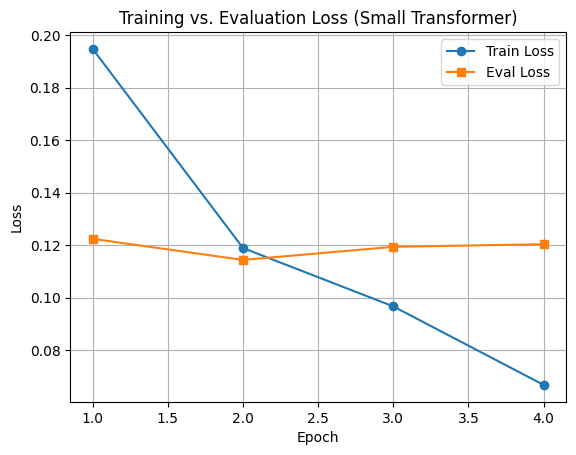

In [41]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, eval_losses, label="Eval Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Evaluation Loss (Small Transformer)")
plt.legend()
plt.grid(True)
plt.show()

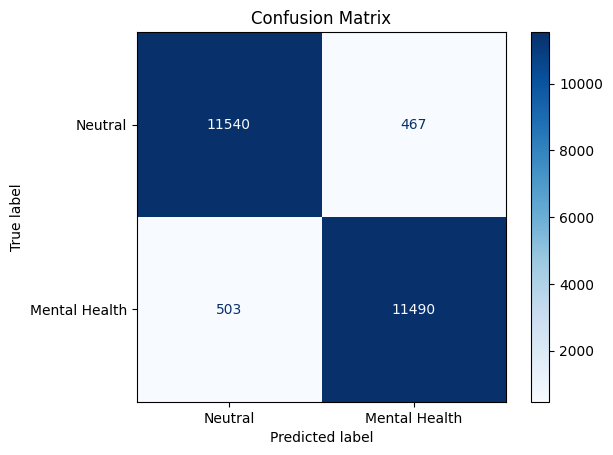

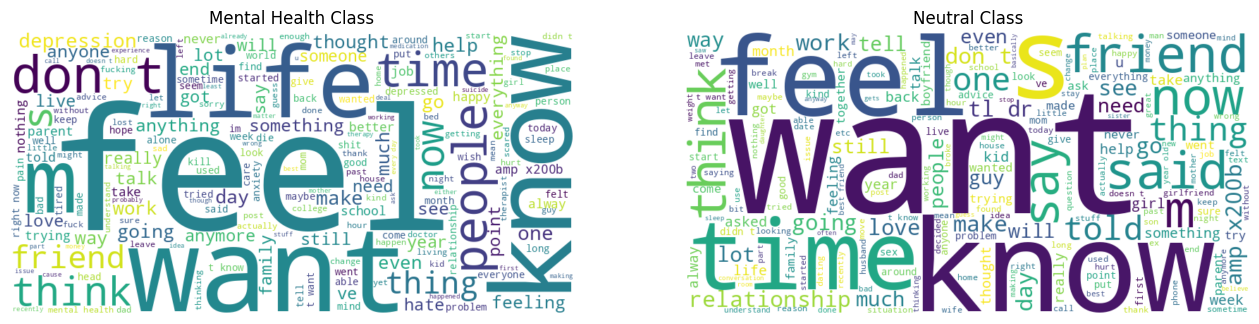

In [42]:
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Neutral", "Mental Health"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

mh_text = " ".join(df[df['label'] == 1]['text'].astype(str))
neutral_text = " ".join(df[df['label'] == 0]['text'].astype(str))

mh_wc = WordCloud(width=800, height=400, background_color='white').generate(mh_text)
neutral_wc = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(mh_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Mental Health Class")

plt.subplot(1,2,2)
plt.imshow(neutral_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Neutral Class")
plt.show()